# 🎉 VAE-Simplified: Decoder-Only with One Time Step

In this notebook, **we'll explore a "VAE-like" model** that omits the encoder altogether and relies on a **single-step fixed corruption process** to act as our "inference." We'll see how the **original ELBO** simplifies into a **noise-prediction objective**, much like in diffusion models — but with just one denoising step.

---

## 🚀 Motivation

Standard VAEs learn both:

1. An **encoder** $ q_\phi(z \mid x) $ that transforms data $x$ into latent code $z$
2. A **decoder** $ p_\theta(x \mid z) $ that reconstructs $x$ from $z$

However, here we **remove** the learned encoder and instead **fix** a one-step noising process that acts as our "latent." In other words:

1. We **corrupt** the input $ x_0 $ into $ x_1 $ by adding Gaussian noise:
   $$
   x_1 = \sqrt{\alpha} \, x_0 \;+\; \sqrt{1 - \alpha}\,\epsilon, 
   \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
   $$

2. We **learn** a decoder $ p_\theta(x_0 \mid x_1) $ that tries to reconstruct $ x_0 $ from $ x_1 $.

This single-step noising is analogous to a **one-step diffusion** but can also be viewed under a **variational** lens — the difference being that our "encoder" is **fixed** by design, rather than learned.

---

## 🔧 Model Setup

1. **Forward / Corruption Process** (fixed):
   $$
   q(x_1 \mid x_0) = \mathcal{N}\!\bigl(x_1; \sqrt{\alpha} \, x_0,\,(1 - \alpha)\,\mathbf{I}\bigr)
   $$
   - We treat $ x_1 $ as a noisy "latent" version of $ x_0 $.

2. **Prior on $ x_1 $**:
   $$
   p(x_1) = \mathcal{N}(x_1; 0, \mathbf{I})
   $$
   (Optionally, we match $ x_1 $ to a standard Gaussian prior, though some setups skip this term.)

3. **Decoder (Denoiser)**:
   $$
   p_\theta(x_0 \mid x_1) 
   $$
   We learn this distribution, typically parameterized by a neural network.  
   - Equivalently, we might learn $ \epsilon_\theta(x_1) $ to predict the noise that was added.

---

## 🧮 ELBO Derivation

### 1. Evidence Lower Bound

We start with the **ELBO** on the data distribution $ p_\theta(x_0) $. We introduce $ x_1 $ as a latent:

$$
\log p_\theta(x_0) 
= \log \int p_\theta(x_0, x_1) \, dx_1
= \log \int p(x_1)\,p_\theta(x_0 \mid x_1)\,dx_1
$$

But we can’t directly evaluate this integral. So we use our **fixed** $ q(x_1 \mid x_0) $ (the noising process) and rewrite:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \frac{p(x_1)\,p_\theta(x_0 \mid x_1)}{q(x_1 \mid x_0)}
\Bigr]
$$

Applying **Jensen’s inequality**:

$$
\log p_\theta(x_0) \;\ge\;
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p(x_1) + \log p_\theta(x_0 \mid x_1) \;-\; \log q(x_1 \mid x_0)
\Bigr]
\;=\; \mathcal{L}_{\text{ELBO}}
$$

Hence,

$$
\mathcal{L}_{\text{ELBO}} 
= 
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p_\theta(x_0 \mid x_1)
  + \log p(x_1)
  - \log q(x_1 \mid x_0)
\Bigr].
$$

---

### 2. 🔍 Breaking Down the ELBO Terms (with Detailed Derivations)

Recall our ELBO:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_1 \mid x_0)}\left[
\log p_\theta(x_0 \mid x_1)
\right]
- D_{\text{KL}}\left(q(x_1 \mid x_0) \,\|\, p(x_1)\right)
$$

We analyze each term in detail.

---

#### 🔹 1. Reconstruction Term:  
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
$$

Assume the decoder is Gaussian:
$$
p_\theta(x_0 \mid x_1) = \mathcal{N}(x_0; \mu_\theta(x_1), \sigma^2 I)
$$

Then:
$$
\log p_\theta(x_0 \mid x_1)
= -\frac{1}{2 \sigma^2} \|x_0 - \mu_\theta(x_1)\|^2 + \text{const}
$$

Therefore, maximizing the log-likelihood is equivalent to **minimizing MSE**:
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
\;\Leftrightarrow\;
- \mathbb{E}_{q(x_1 \mid x_0)}\left[ \|x_0 - \mu_\theta(x_1)\|^2 \right]
$$

This is the traditional **reconstruction loss**, but it still depends on predicting the clean image $ x_0 $.

---

#### 🔹 2. KL Term (Prior Matching):  
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, p(x_1))
$$

Assume:
- $ q(x_1 \mid x_0) = \mathcal{N}(x_1; \sqrt{\alpha} x_0, (1 - \alpha) I) $
- $ p(x_1) = \mathcal{N}(0, I) $

Then we can use the KL formula for two Gaussians:
$$
D_{\text{KL}}(\mathcal{N}(\mu_1, \Sigma_1) \,\|\, \mathcal{N}(\mu_2, \Sigma_2)) = 
\frac{1}{2} \left[
\text{tr}(\Sigma_2^{-1} \Sigma_1)
+ (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1)
- k + \log \left( \frac{\det \Sigma_2}{\det \Sigma_1} \right)
\right]
$$

Plug in:
- $ \mu_1 = \sqrt{\alpha} x_0 $, $ \Sigma_1 = (1 - \alpha) I $
- $ \mu_2 = 0 $, $ \Sigma_2 = I $

We get:
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, \mathcal{N}(0, I)) =
\frac{1}{2} \left[
\frac{d (1 - \alpha)}{1} + \frac{\|\sqrt{\alpha} x_0\|^2}{1}
- d + \log\left( \frac{1}{(1 - \alpha)^d} \right)
\right]
$$

This evaluates to a **closed-form scalar**, which depends on $ x_0 $, but **does not require learning** — so it can be ignored or precomputed.

---

## 🔑 Connection to Noise Prediction

Instead of predicting $ x_0 $ from $ x_1 $, we **predict the noise $ \epsilon $** that was added during the forward process:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon,
\quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$

Rewriting:
$$
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
\quad \Rightarrow \quad
x_0 = \frac{x_1 - \sqrt{1 - \alpha} \epsilon}{\sqrt{\alpha}}
$$

Now suppose we train a model $ \epsilon_\theta(x_1) $ to **predict this noise**.

Substitute the predicted $ \hat{\epsilon}_\theta $ back into the expression for $ \mu_\theta(x_1) $:

$$
\hat{x}_0 = \frac{1}{\sqrt{\alpha}} \left( x_1 - \sqrt{1 - \alpha} \, \hat{\epsilon}_\theta(x_1) \right)
$$

So predicting $ \epsilon $ is **equivalent to** predicting $ x_0 $, but in a different form.

---

### 🎯 Why This Works

We assume the **true posterior** is:

$$
q(x_1 \mid x_0) = \mathcal{N}(\sqrt{\alpha} x_0, (1 - \alpha) I)
$$

If we know $ x_1 $, the most informative thing to do is to **recover $ x_0 $** — and we can do this by first predicting $ \epsilon $, because:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon \;\Rightarrow\;
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
$$

So predicting $ \epsilon $ is as good as predicting $ x_0 $, but it's **easier** and has **less variance**.

---

### ✅ Final Noise Prediction Objective

We define:

$$
\mathcal{L}_{\text{simple}} =
\mathbb{E}_{x_0 \sim \text{data}, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_1) \right\|^2
\right],
\quad \text{where } x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon
$$

This objective is **equivalent to maximizing the original ELBO**, under the assumptions that:
- $ p_\theta(x_0 \mid x_1) $ is Gaussian with fixed variance
- $ p(x_1) $ is Gaussian prior
- We're ignoring the constant KL term

So instead of learning to reconstruct $ x_0 $, we **learn to denoise the corruption** — which is a **simplified variational training objective**.

---

## ✅ Summary

- **We fix a one-step Gaussian corruption** to transform $ x_0 $ into $ x_1$. 
- **We learn a single-step decoder** $ p_\theta(x_0 \mid x_1) $ (or noise predictor $\epsilon_\theta$).
- **Our ELBO** breaks down into a reconstruction term and a KL term that aligns $ x_1 $ with a prior. 
- By parameterizing the decoder to predict **noise** rather than $ x_0$, the resulting **loss** is essentially an **MSE** between true noise $\epsilon$ and $\epsilon_\theta(x_1)$.

This **mirrors** the key simplification in standard DDPMs, but restricted to **just one step**. It’s not a “VAE” in the classic sense (no learned encoder), but it’s still a **variational model** with **fixed inference** and **learned generative** processes.

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)


# 🚀 Extended Explanation of the Code: U-Net for Single-Step Denoising

Below is a **supplement** to the "VAE-Simplified" discussion. It explains the **U-Net architecture** used in this notebook as a **noise predictor** for the single-step corruption model.

---

## 1. **ShuffleNet-Based UNet Architecture**

For the task of predicting noise from a corrupted image $x_1$, we employ a U-Net architecture. This U-Net is constructed using ShuffleNet-style blocks for efficiency.

1.  **UNet Core Structure**:
    *   **Encoder Path**: Gradually downsamples the input image, increasing channel depth. This path captures contextual information. It consists of `EncoderBlock` modules.
        *   Each `EncoderBlock` typically contains several `ResidualBottleneck` layers (to process features at the current resolution) followed by a `ResidualDownsample` layer (to reduce spatial dimensions and increase channels).
    *   **Bottleneck**: A middle part of the network that processes features at the lowest spatial resolution, having a large receptive field.
    *   **Decoder Path**: Gradually upsamples the features, decreasing channel depth, to reconstruct the desired output (in our case, the predicted noise). This path uses `DecoderBlock` modules.
        *   Each `DecoderBlock` typically starts with an `Upsample` layer, concatenates features from the corresponding encoder block (skip connection), and then processes them through `ResidualBottleneck` layers.
    *   **Skip Connections**: These connections pass feature maps from the encoder blocks directly to the corresponding decoder blocks. This helps the decoder recover finer details lost during downsampling and aids in gradient flow.

2.  **ShuffleNet Modules**:
    *   Instead of standard convolutional or residual blocks, our U-Net uses `ResidualBottleneck` and `ResidualDownsample` modules inspired by ShuffleNet.
    *   **Depthwise and Grouped Convolutions**: These modules utilize depthwise separable convolutions or grouped convolutions, which are more parameter-efficient than standard convolutions.
    *   **Channel Splitting and Shuffling**: A key characteristic of ShuffleNet blocks is splitting channels into groups, processing them in parallel branches, and then concatenating and shuffling them. This promotes information flow between channel groups.
        *   In code: `x1, x2 = x.chunk(2, dim=1)` splits feature maps, which are then processed by separate branches and recombined. `ChannelShuffle` permutes channels.
    *   **Why for MNIST?**: While a full ShuffleNet-UNet might be considered powerful for $28 \times 28$ MNIST images, it demonstrates a scalable and efficient architectural pattern. These blocks act as lightweight alternatives to more complex residual blocks.

3.  **U-Net in `02.vae-without-encoder.ipynb`**:
    *   The `Unet` class in this notebook's code implements this architecture.
    *   Crucially, for this single-step model, the U-Net **does not use time embeddings**. The corruption is fixed (a single $\alpha$ value), so the network doesn't need to adapt to different noise levels via time conditioning. Its task is to denoise $x_1$ which always has a similar noise characteristic defined by the chosen $\alpha$.

---

## 2. **U-Net as a Noise Predictor in the Single-Step Model**

In this notebook's "VAE-Simplified" setup:
1.  An original image $x_0$ is corrupted to $x_1$ using a fixed process:
    $x_1 = \sqrt{\alpha} \, x_0 + \sqrt{1 - \alpha}\,\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.
2.  The U-Net, denoted $\epsilon_\theta(x_1)$, is trained to predict the noise $\epsilon$ that was added to $x_0$ to produce $x_1$.
    *   **Input**: The noisy image $x_1$.
    *   **Output**: The predicted noise $\hat{\epsilon} = \epsilon_\theta(x_1)$.

The U-Net's encoder-decoder structure with skip connections is well-suited for this image-to-image task, allowing it to capture multi-scale features of the noisy input to accurately estimate the noise pattern.

---

## 3. **Training and Sampling**

1.  **Training**:
    *   The model is trained by minimizing the Mean Squared Error (MSE) between the true noise $\epsilon$ and the predicted noise $\hat{\epsilon}$:
        $\mathcal{L} = \| \epsilon - \epsilon_\theta(x_1) \|^2$.
    *   For each training step:
        *   Take a batch of clean images $x_0$.
        *   Generate noise $\epsilon$.
        *   Compute $x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon$.
        *   Pass $x_1$ through the U-Net to get $\hat{\epsilon}$.
        *   Compute the MSE loss and update the U-Net's parameters $\theta$.

2.  **Sampling (Generating New Images)**:
    *   To generate a new image $\hat{x}_0$:
        1.  First, we need a sample of $x_1$. The code estimates the mean and standard deviation of $x_1$ from the training data (corrupted by the fixed $\alpha$) and then samples `x1_gen = x1_mean + x1_std * eps_gen_for_x1`, where `eps_gen_for_x1` is random Gaussian noise.
        2.  Pass this $x_1^{gen}$ through the trained U-Net: $\hat{\epsilon}_{gen} = \epsilon_\theta(x_1^{gen})$.
        3.  Reconstruct an estimate of the clean image $\hat{x}_0$ using the predicted noise:
            $\hat{x}_0 = \frac{1}{\sqrt{\alpha}} (x_1^{gen} - \sqrt{1 - \alpha} \, \hat{\epsilon}_{gen})$.
        4.  The result $\hat{x}_0$ is then clamped and normalized for visualization.

---

## 4. **Conclusion for Single-Step Denoising**

*   The ShuffleNet-based U-Net provides a capable architecture for the noise prediction task in this simplified, single-step generative model.
*   This setup serves as an illustrative step towards understanding more complex diffusion models. It highlights the core idea of learning a denoiser.
*   However, as observed, single-step denoising with a fixed corruption level has limitations. The quality of generated images may not be high, and $x_1$ isn't truly a standard Gaussian unless $\alpha$ is very small (which would erase most of the signal from $x_0$). This motivates the multi-step approach seen in full diffusion models.

You now have a map of how the U-Net architecture is employed and trained within the context of the single-step "VAE-without-encoder" model.

## References

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm


###############################################################################
# 1) Model Components
###############################################################################
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        N, C, H, W = x.shape
        assert C % self.groups == 0
        x = x.view(N, self.groups, C // self.groups, H, W)
        x = x.transpose(1, 2).contiguous()
        x = x.view(N, C, H, W)
        return x


class ConvBnSiLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.module(x)


class ResidualBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels // 2, in_channels // 2, 1, 1, 0),
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        out = torch.cat([self.branch1(x1), self.branch2(x2)], dim=1)
        return self.channel_shuffle(out)


class ResidualDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 2, 1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
            nn.Conv2d(
                out_channels // 2, out_channels // 2, 3, 2, 1, groups=out_channels // 2
            ),
            nn.BatchNorm2d(out_channels // 2),
            ConvBnSiLu(out_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        out = torch.cat([self.branch1(x), self.branch2(x)], dim=1)
        return self.channel_shuffle(out)


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_res_blocks=3):
        super().__init__()
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(num_res_blocks)],
            ResidualBottleneck(in_channels, out_channels // 2),
        )
        self.act = nn.SiLU()
        self.conv1 = ResidualDownsample(out_channels // 2, out_channels)

    def forward(self, x):
        x_short = self.conv0(x)
        x_short = self.act(x_short)
        x_down = self.conv1(x_short)
        return x_down, x_short


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_res_blocks=3):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(num_res_blocks)],
            ResidualBottleneck(in_channels, in_channels // 2),
        )
        self.act = nn.SiLU()
        self.conv1 = ResidualBottleneck(in_channels // 2, out_channels // 2)

    def forward(self, x, x_short):
        x = self.up(x)
        if x.shape[2] > x_short.shape[2] or x.shape[3] > x_short.shape[3]:
            target_h, target_w = x_short.shape[2], x_short.shape[3]
            x = x[:, :, :target_h, :target_w]
        
        x = torch.cat([x, x_short], dim=1)
        x = self.conv0(x)
        x = self.act(x)
        x = self.conv1(x)
        return x


class Unet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        base_dim=64,
        dim_mults=(1, 2, 4),
        num_res_blocks_encoder=2,
        num_res_blocks_decoder=2,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        self.init_conv = ConvBnSiLu(in_channels, base_dim, 3, 1, 1)

        self.channels_config = []
        current_dim = base_dim
        for i, mult in enumerate(dim_mults):
            out_dim = base_dim * mult
            self.channels_config.append((current_dim, out_dim))
            current_dim = out_dim

        self.enc_blocks = nn.ModuleList()
        for c_in, c_out in self.channels_config:
            self.enc_blocks.append(
                EncoderBlock(c_in, c_out, num_res_blocks=num_res_blocks_encoder)
            )

        mid_channels_in = self.channels_config[-1][1]
        self.mid_block = nn.Sequential(
            *[ResidualBottleneck(mid_channels_in, mid_channels_in) for _ in range(num_res_blocks_mid)],
            ResidualBottleneck(mid_channels_in, mid_channels_in // 2)
        )
        mid_channels_out = mid_channels_in // 2

        self.dec_blocks = nn.ModuleList()
        current_dec_in_dim = mid_channels_out
        
        for i in reversed(range(len(self.channels_config))):
            skip_channels = self.channels_config[i][1] // 2
            dec_block_out_target = self.channels_config[i][0]
            
            self.dec_blocks.append(
                DecoderBlock(current_dec_in_dim + skip_channels, dec_block_out_target * 2, num_res_blocks=num_res_blocks_decoder)
            )
            current_dec_in_dim = dec_block_out_target

        last_dec_output_channels = self.channels_config[0][0]
        self.final_conv = nn.Conv2d(last_dec_output_channels, out_channels, 1)

    def forward(self, x):
        x = self.init_conv(x)
        skips = []
        for enc_block in self.enc_blocks:
            x, x_short = enc_block(x)
            skips.append(x_short)

        x = self.mid_block(x)

        skips.reverse()
        for i, dec_block in enumerate(self.dec_blocks):
            x = dec_block(x, skips[i])

        return self.final_conv(x)


class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dims=(32, 64, 32)):
        super().__init__()
        layers = []
        current_channels = in_channels
        for h_dim in hidden_dims:
            # Using kernel_size=3 and padding=1 to maintain spatial dimensions
            layers.append(ConvBnSiLu(current_channels, h_dim, kernel_size=3, padding=1))
            current_channels = h_dim
        # Final convolution to get to out_channels, also maintaining dimensions
        layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


###############################################################################
# 2) One-Step Loss
###############################################################################
def noise_predictor_loss(x0, model, alpha=0.9):
    eps = torch.randn_like(x0)
    x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps
    eps_hat = model(x1)
    loss = F.mse_loss(eps_hat, eps, reduction="sum")
    return loss, x1, eps, eps_hat


###############################################################################
# 3) Estimate x1 Stats
###############################################################################
def estimate_x1_stats(dataloader, alpha=0.9, device="cpu"):
    x1_list = []
    print("Estimating x1 statistics...")
    for x0, _ in tqdm(dataloader, desc="Estimating x1 stats", leave=False):
        x0 = x0.to(device)
        eps = torch.randn_like(x0)
        x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps
        x1_list.append(x1.cpu())

    x1_all = torch.cat(x1_list, dim=0)
    x1_mean = x1_all.mean(dim=0, keepdim=True)
    x1_std = x1_all.std(dim=0, keepdim=True)
    print("Finished estimating x1 statistics.")
    return x1_mean, x1_std


###############################################################################
# 4) Main Training + Sampling
###############################################################################
def run_noise_predictor(
    # General parameters
    model_type: str = "unet", # "unet" or "simple_cnn"
    alpha=0.9,
    epochs=20,
    batch_size=128,
    lr=1e-3,
    show_every=10,
    log_freq=50,
    n_samples=16,
    # Unet specific parameters
    base_dim=32,
    dim_mults=(1, 2, 4),
    num_res_blocks_encoder=2,
    num_res_blocks_decoder=2,
    num_res_blocks_mid=2,
    # SimpleCNN specific parameters
    simple_cnn_hidden_dims=(32, 64, 128, 64, 32),
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Selected model type: {model_type}")

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    train_data = datasets.MNIST(
        "./data", train=True, download=True, transform=transform
    )
    stat_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True if device.type == "cuda" else False,
    )
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True if device.type == "cuda" else False,
    )

    x1_mean_cpu, x1_std_cpu = estimate_x1_stats(stat_loader, alpha=alpha, device=device)

    if model_type == "unet":
        model = Unet(
            in_channels=1,
            out_channels=1,
            base_dim=base_dim,
            dim_mults=dim_mults,
            num_res_blocks_encoder=num_res_blocks_encoder,
            num_res_blocks_decoder=num_res_blocks_decoder,
            num_res_blocks_mid=num_res_blocks_mid,
        ).to(device)
    elif model_type == "simple_cnn":
        model = SimpleCNN(
            in_channels=1,
            out_channels=1,
            hidden_dims=simple_cnn_hidden_dims
        ).to(device)
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Choose 'unet' or 'simple_cnn'.")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters ({model_type.upper()}): {num_params:,}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss_sum = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for batch_idx, (x_batch, _) in progress_bar:
            x_batch = x_batch.to(device)
            loss, _, _, _ = noise_predictor_loss(x_batch, model, alpha=alpha)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss_sum += loss.item()
            
            if (batch_idx + 1) % log_freq == 0 or (batch_idx + 1) == len(train_loader):
                current_batch_loss_avg = loss.item() / x_batch.size(0)
                progress_bar.set_postfix(batch_loss=f'{current_batch_loss_avg:.4f}')
        
        avg_epoch_loss = epoch_loss_sum / len(train_loader.dataset)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % show_every == 0 or (epoch == epochs - 1):
            model.eval()
            with torch.no_grad():
                eps_gen_for_x1 = torch.randn(n_samples, 1, 28, 28, device=device)
                x1_mean = x1_mean_cpu.to(device)
                x1_std = x1_std_cpu.to(device)
                x1_gen = x1_mean + x1_std * eps_gen_for_x1

                eps_hat_gen = model(x1_gen)

                safe_alpha = max(alpha, 1e-6)
                x0_hat = (x1_gen - ((1 - safe_alpha) ** 0.5) * eps_hat_gen) / (
                    safe_alpha**0.5
                )
                x0_hat = x0_hat.clamp(-1.0, 1.0)
                x0_vis = (x0_hat + 1.0) / 2.0
                x0_vis = x0_vis.clamp(0.0, 1.0)

                grid = torchvision.utils.make_grid(x0_vis, nrow=int(math.sqrt(n_samples)), padding=2)
                fig_size_factor = max(4, int(math.sqrt(n_samples)) * 1.0)
                plt.figure(figsize=(fig_size_factor, fig_size_factor))
                plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
                plt.title(f"Generated Samples (Epoch {epoch+1}, Model: {model_type.upper()})")
                plt.axis("off")
                plt.show()

/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




--- Training SimpleCNN Model ---
Using device: cuda
Selected model type: simple_cnn
Estimating x1 statistics...


Finished estimating x1 statistics.
Trainable Parameters (SIMPLE_CNN): 149,377


Epoch 1/100: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s, batch_loss=44.7987]

Epoch [1/100] - Avg Loss: 64.5519



Epoch 2/100: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s, batch_loss=40.4112]

Epoch [2/100] - Avg Loss: 42.3843



Epoch 3/100: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s, batch_loss=39.0729]

Epoch [3/100] - Avg Loss: 40.0582



Epoch 4/100: 100%|██████████| 235/235 [00:18<00:00, 12.89it/s, batch_loss=37.5037]

Epoch [4/100] - Avg Loss: 38.8195



Epoch 5/100: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s, batch_loss=40.1676]

Epoch [5/100] - Avg Loss: 37.9584



Epoch 6/100: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s, batch_loss=36.5350]

Epoch [6/100] - Avg Loss: 37.4526



Epoch 7/100: 100%|██████████| 235/235 [00:18<00:00, 12.87it/s, batch_loss=36.3393]

Epoch [7/100] - Avg Loss: 37.0293



Epoch 8/100: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s, batch_loss=35.9987]

Epoch [8/100] - Avg Loss: 36.7201



Epoch 9/100: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s, batch_loss=37.6882]

Epoch [9/100] - Avg Loss: 36.4447



Epoch 10/100: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s, batch_loss=35.4843]


Epoch [10/100] - Avg Loss: 36.2677


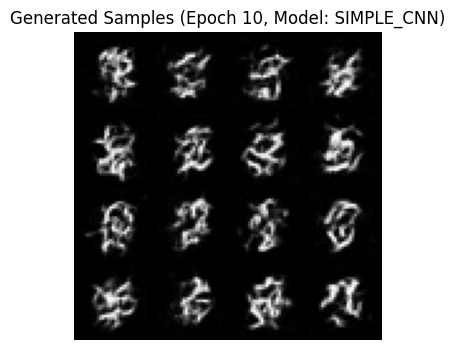

Epoch 11/100: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s, batch_loss=34.8581]

Epoch [11/100] - Avg Loss: 36.0985



Epoch 12/100: 100%|██████████| 235/235 [00:17<00:00, 13.07it/s, batch_loss=37.5821]

Epoch [12/100] - Avg Loss: 35.9575



Epoch 13/100: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s, batch_loss=36.4057]

Epoch [13/100] - Avg Loss: 35.8515



Epoch 14/100: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s, batch_loss=34.2721]

Epoch [14/100] - Avg Loss: 35.7344



Epoch 15/100: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s, batch_loss=33.9428]

Epoch [15/100] - Avg Loss: 35.7188



Epoch 16/100: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s, batch_loss=35.4036]

Epoch [16/100] - Avg Loss: 35.5402



Epoch 17/100: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s, batch_loss=38.1260]

Epoch [17/100] - Avg Loss: 35.4427



Epoch 18/100: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s, batch_loss=33.3141]

Epoch [18/100] - Avg Loss: 35.3589



Epoch 19/100: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s, batch_loss=36.7832]

Epoch [19/100] - Avg Loss: 35.3845



Epoch 20/100: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s, batch_loss=35.3009]

Epoch [20/100] - Avg Loss: 35.1430


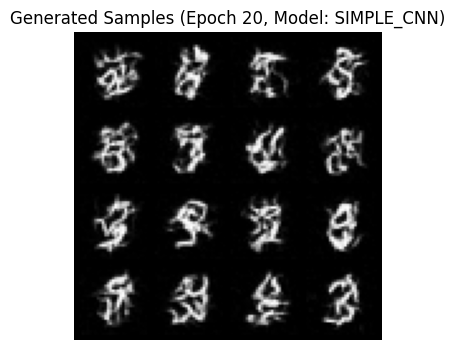

Epoch 21/100: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s, batch_loss=35.3249]

Epoch [21/100] - Avg Loss: 35.1551



Epoch 22/100: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s, batch_loss=36.6042]

Epoch [22/100] - Avg Loss: 35.1200



Epoch 23/100: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s, batch_loss=35.6501]

Epoch [23/100] - Avg Loss: 34.9770



Epoch 24/100: 100%|██████████| 235/235 [00:18<00:00, 12.59it/s, batch_loss=37.3733]

Epoch [24/100] - Avg Loss: 35.0358



Epoch 25/100: 100%|██████████| 235/235 [00:18<00:00, 12.43it/s, batch_loss=35.3957]

Epoch [25/100] - Avg Loss: 34.8988



Epoch 26/100: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s, batch_loss=35.0696]

Epoch [26/100] - Avg Loss: 34.9050



Epoch 27/100: 100%|██████████| 235/235 [00:17<00:00, 13.17it/s, batch_loss=33.5633]

Epoch [27/100] - Avg Loss: 34.7928



Epoch 28/100: 100%|██████████| 235/235 [00:18<00:00, 12.53it/s, batch_loss=33.8727]

Epoch [28/100] - Avg Loss: 34.7524



Epoch 29/100: 100%|██████████| 235/235 [00:18<00:00, 12.76it/s, batch_loss=36.1453]

Epoch [29/100] - Avg Loss: 34.7113



Epoch 30/100: 100%|██████████| 235/235 [00:19<00:00, 12.36it/s, batch_loss=33.7063]

Epoch [30/100] - Avg Loss: 34.7200


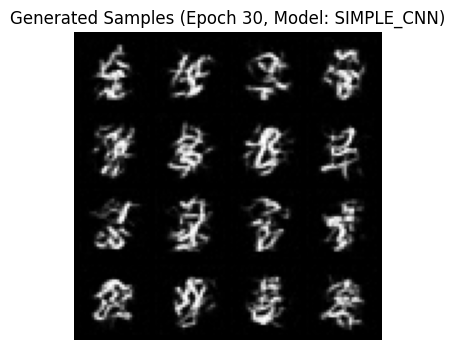

Epoch 31/100: 100%|██████████| 235/235 [00:18<00:00, 12.54it/s, batch_loss=33.2965]

Epoch [31/100] - Avg Loss: 34.6400



Epoch 32/100: 100%|██████████| 235/235 [00:18<00:00, 12.56it/s, batch_loss=36.4441]

Epoch [32/100] - Avg Loss: 34.6957



Epoch 33/100: 100%|██████████| 235/235 [00:18<00:00, 12.66it/s, batch_loss=33.8755]

Epoch [33/100] - Avg Loss: 34.5733



Epoch 34/100: 100%|██████████| 235/235 [00:18<00:00, 12.75it/s, batch_loss=33.4542]

Epoch [34/100] - Avg Loss: 34.5508



Epoch 35/100: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s, batch_loss=35.7058]

Epoch [35/100] - Avg Loss: 34.6095



Epoch 36/100: 100%|██████████| 235/235 [00:17<00:00, 13.52it/s, batch_loss=32.2094]

Epoch [36/100] - Avg Loss: 34.4431



Epoch 37/100: 100%|██████████| 235/235 [00:17<00:00, 13.50it/s, batch_loss=35.5643]

Epoch [37/100] - Avg Loss: 34.4372



Epoch 38/100: 100%|██████████| 235/235 [00:17<00:00, 13.50it/s, batch_loss=34.3156]

Epoch [38/100] - Avg Loss: 34.4406



Epoch 39/100: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s, batch_loss=32.0943]

Epoch [39/100] - Avg Loss: 34.3339



Epoch 40/100: 100%|██████████| 235/235 [00:17<00:00, 13.50it/s, batch_loss=30.9220]

Epoch [40/100] - Avg Loss: 34.3804


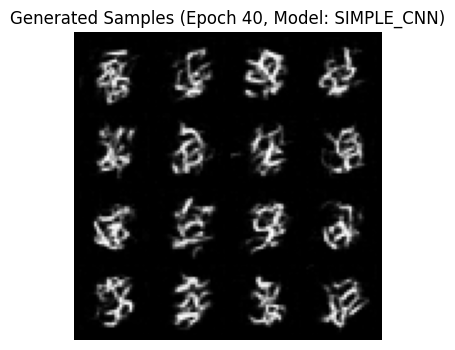

Epoch 41/100: 100%|██████████| 235/235 [00:17<00:00, 13.51it/s, batch_loss=33.6831]

Epoch [41/100] - Avg Loss: 34.3897



Epoch 42/100: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s, batch_loss=32.6000]

Epoch [42/100] - Avg Loss: 34.3614



Epoch 43/100: 100%|██████████| 235/235 [00:17<00:00, 13.47it/s, batch_loss=34.3601]

Epoch [43/100] - Avg Loss: 34.2817



Epoch 44/100: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s, batch_loss=35.5298]

Epoch [44/100] - Avg Loss: 34.3134



Epoch 45/100: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s, batch_loss=34.7085]

Epoch [45/100] - Avg Loss: 34.2741



Epoch 46/100: 100%|██████████| 235/235 [00:17<00:00, 13.47it/s, batch_loss=36.6942]

Epoch [46/100] - Avg Loss: 34.1962



Epoch 47/100: 100%|██████████| 235/235 [00:17<00:00, 13.51it/s, batch_loss=35.0695]

Epoch [47/100] - Avg Loss: 34.2547



Epoch 48/100: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s, batch_loss=32.7368]

Epoch [48/100] - Avg Loss: 34.2034



Epoch 49/100: 100%|██████████| 235/235 [00:17<00:00, 13.46it/s, batch_loss=34.2710]

Epoch [49/100] - Avg Loss: 34.1495



Epoch 50/100: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s, batch_loss=36.2871]

Epoch [50/100] - Avg Loss: 34.1561


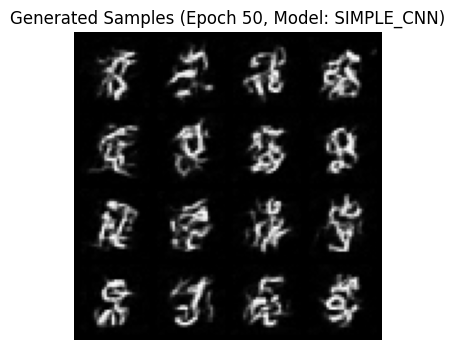

Epoch 51/100: 100%|██████████| 235/235 [00:17<00:00, 13.46it/s, batch_loss=33.6438]

Epoch [51/100] - Avg Loss: 34.1223



Epoch 52/100: 100%|██████████| 235/235 [00:18<00:00, 12.61it/s, batch_loss=32.7857]

Epoch [52/100] - Avg Loss: 34.1630



Epoch 53/100: 100%|██████████| 235/235 [00:18<00:00, 12.68it/s, batch_loss=34.0544]

Epoch [53/100] - Avg Loss: 34.1290



Epoch 54/100: 100%|██████████| 235/235 [00:18<00:00, 12.63it/s, batch_loss=35.0453]

Epoch [54/100] - Avg Loss: 34.0065



Epoch 55/100: 100%|██████████| 235/235 [00:18<00:00, 12.69it/s, batch_loss=34.1187]

Epoch [55/100] - Avg Loss: 34.0587



Epoch 56/100: 100%|██████████| 235/235 [00:18<00:00, 12.60it/s, batch_loss=33.9467]

Epoch [56/100] - Avg Loss: 34.0521



Epoch 57/100: 100%|██████████| 235/235 [00:18<00:00, 12.53it/s, batch_loss=35.8918]

Epoch [57/100] - Avg Loss: 34.0251



Epoch 58/100: 100%|██████████| 235/235 [00:18<00:00, 12.57it/s, batch_loss=33.2273]

Epoch [58/100] - Avg Loss: 33.9993



Epoch 59/100: 100%|██████████| 235/235 [00:16<00:00, 14.01it/s, batch_loss=34.0226]

Epoch [59/100] - Avg Loss: 34.0002



Epoch 60/100: 100%|██████████| 235/235 [00:17<00:00, 13.79it/s, batch_loss=33.5753]

Epoch [60/100] - Avg Loss: 34.0115


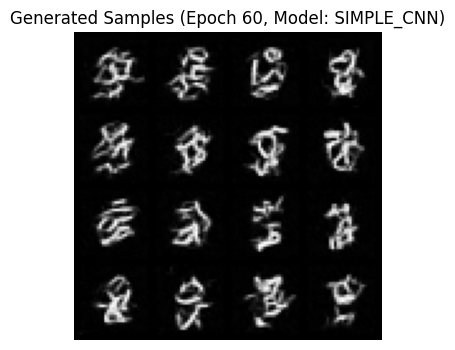

Epoch 61/100: 100%|██████████| 235/235 [00:17<00:00, 13.77it/s, batch_loss=36.1760]

Epoch [61/100] - Avg Loss: 33.9525



Epoch 62/100: 100%|██████████| 235/235 [00:17<00:00, 13.81it/s, batch_loss=34.2838]

Epoch [62/100] - Avg Loss: 33.9500



Epoch 63/100: 100%|██████████| 235/235 [00:17<00:00, 13.53it/s, batch_loss=34.0552]

Epoch [63/100] - Avg Loss: 33.8830



Epoch 64/100: 100%|██████████| 235/235 [00:17<00:00, 13.46it/s, batch_loss=33.1570]

Epoch [64/100] - Avg Loss: 33.8970



Epoch 65/100: 100%|██████████| 235/235 [00:16<00:00, 13.84it/s, batch_loss=33.3443]

Epoch [65/100] - Avg Loss: 33.8661



Epoch 66/100: 100%|██████████| 235/235 [00:17<00:00, 13.43it/s, batch_loss=32.3138]

Epoch [66/100] - Avg Loss: 33.8439



Epoch 67/100: 100%|██████████| 235/235 [00:17<00:00, 13.51it/s, batch_loss=33.7281]

Epoch [67/100] - Avg Loss: 33.8709



Epoch 68/100: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s, batch_loss=35.9610]

Epoch [68/100] - Avg Loss: 33.8254



Epoch 69/100: 100%|██████████| 235/235 [00:18<00:00, 12.52it/s, batch_loss=33.9617]

Epoch [69/100] - Avg Loss: 33.7724



Epoch 70/100: 100%|██████████| 235/235 [00:18<00:00, 12.67it/s, batch_loss=32.8187]

Epoch [70/100] - Avg Loss: 33.7825


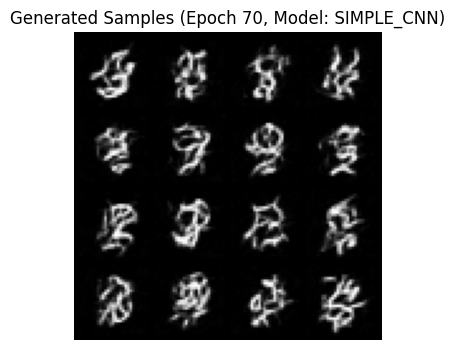

Epoch 71/100: 100%|██████████| 235/235 [00:18<00:00, 12.55it/s, batch_loss=33.5630]

Epoch [71/100] - Avg Loss: 33.8387



Epoch 72/100: 100%|██████████| 235/235 [00:18<00:00, 12.47it/s, batch_loss=33.2201]

Epoch [72/100] - Avg Loss: 33.7839



Epoch 73/100: 100%|██████████| 235/235 [00:18<00:00, 12.73it/s, batch_loss=33.9872]

Epoch [73/100] - Avg Loss: 33.7859



Epoch 74/100: 100%|██████████| 235/235 [00:17<00:00, 13.13it/s, batch_loss=31.7011]

Epoch [74/100] - Avg Loss: 33.8053



Epoch 75/100: 100%|██████████| 235/235 [00:17<00:00, 13.51it/s, batch_loss=33.8029]

Epoch [75/100] - Avg Loss: 33.7474



Epoch 76/100: 100%|██████████| 235/235 [00:17<00:00, 13.39it/s, batch_loss=34.0492]

Epoch [76/100] - Avg Loss: 33.6895



Epoch 77/100: 100%|██████████| 235/235 [00:17<00:00, 13.44it/s, batch_loss=33.1619]

Epoch [77/100] - Avg Loss: 33.7662



Epoch 78/100: 100%|██████████| 235/235 [00:18<00:00, 12.69it/s, batch_loss=33.7550]

Epoch [78/100] - Avg Loss: 33.7188



Epoch 79/100: 100%|██████████| 235/235 [00:18<00:00, 12.49it/s, batch_loss=32.8913]

Epoch [79/100] - Avg Loss: 33.7006



Epoch 80/100: 100%|██████████| 235/235 [00:18<00:00, 12.54it/s, batch_loss=34.8743]

Epoch [80/100] - Avg Loss: 33.7264


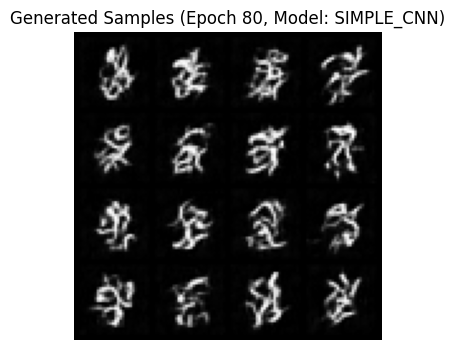

Epoch 81/100: 100%|██████████| 235/235 [00:18<00:00, 12.50it/s, batch_loss=34.6689]

Epoch [81/100] - Avg Loss: 33.7202



Epoch 82/100: 100%|██████████| 235/235 [00:18<00:00, 12.52it/s, batch_loss=32.9217]

Epoch [82/100] - Avg Loss: 33.6846



Epoch 83/100: 100%|██████████| 235/235 [00:18<00:00, 12.55it/s, batch_loss=32.2936]

Epoch [83/100] - Avg Loss: 33.7079



Epoch 84/100: 100%|██████████| 235/235 [00:18<00:00, 12.50it/s, batch_loss=34.6317]

Epoch [84/100] - Avg Loss: 33.7034



Epoch 85/100: 100%|██████████| 235/235 [00:18<00:00, 12.51it/s, batch_loss=32.6843]

Epoch [85/100] - Avg Loss: 33.5944



Epoch 86/100: 100%|██████████| 235/235 [00:18<00:00, 12.55it/s, batch_loss=34.0171]

Epoch [86/100] - Avg Loss: 33.6446



Epoch 87/100: 100%|██████████| 235/235 [00:18<00:00, 12.56it/s, batch_loss=33.8042]

Epoch [87/100] - Avg Loss: 33.6874



Epoch 88/100: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s, batch_loss=33.3452]

Epoch [88/100] - Avg Loss: 33.6559



Epoch 89/100: 100%|██████████| 235/235 [00:18<00:00, 12.65it/s, batch_loss=36.1572]

Epoch [89/100] - Avg Loss: 33.5998



Epoch 90/100: 100%|██████████| 235/235 [00:18<00:00, 12.59it/s, batch_loss=33.7795]

Epoch [90/100] - Avg Loss: 33.6400


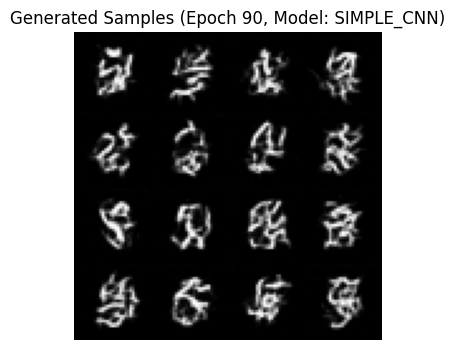

Epoch 91/100: 100%|██████████| 235/235 [00:18<00:00, 12.53it/s, batch_loss=33.7855]

Epoch [91/100] - Avg Loss: 33.5619



Epoch 92/100: 100%|██████████| 235/235 [00:18<00:00, 12.51it/s, batch_loss=34.2339]

Epoch [92/100] - Avg Loss: 33.5842



Epoch 93/100: 100%|██████████| 235/235 [00:18<00:00, 12.48it/s, batch_loss=33.9850]

Epoch [93/100] - Avg Loss: 33.5491



Epoch 94/100: 100%|██████████| 235/235 [00:18<00:00, 12.51it/s, batch_loss=32.8718]

Epoch [94/100] - Avg Loss: 33.6105



Epoch 95/100: 100%|██████████| 235/235 [00:18<00:00, 12.52it/s, batch_loss=33.5507]

Epoch [95/100] - Avg Loss: 33.5808



Epoch 96/100: 100%|██████████| 235/235 [00:18<00:00, 12.51it/s, batch_loss=33.1427]

Epoch [96/100] - Avg Loss: 33.5762



Epoch 97/100: 100%|██████████| 235/235 [00:18<00:00, 12.56it/s, batch_loss=34.3661]

Epoch [97/100] - Avg Loss: 33.5581



Epoch 98/100: 100%|██████████| 235/235 [00:18<00:00, 12.51it/s, batch_loss=33.8183]

Epoch [98/100] - Avg Loss: 33.5172



Epoch 99/100: 100%|██████████| 235/235 [00:18<00:00, 12.46it/s, batch_loss=34.3298]

Epoch [99/100] - Avg Loss: 33.5400



Epoch 100/100: 100%|██████████| 235/235 [00:18<00:00, 12.53it/s, batch_loss=32.8333]

Epoch [100/100] - Avg Loss: 33.5541


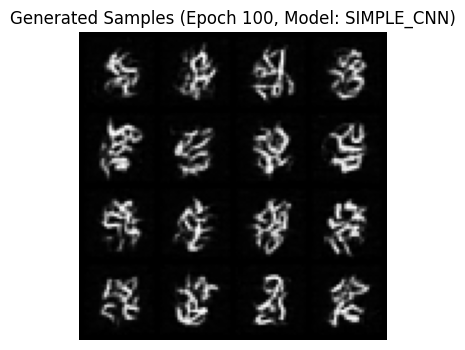

In [2]:
print("\n\n--- Training SimpleCNN Model ---")
# Example 2: Run with the SimpleCNN model
run_noise_predictor(
    model_type="simple_cnn", # Specify SimpleCNN
    alpha=0.7,
    epochs=100, # SimpleCNN might train faster or need fewer epochs
    batch_size=256,
    lr=1e-3,   # SimpleCNN might tolerate a higher LR
    show_every=10, # Show every 5 epochs for SimpleCNN
    simple_cnn_hidden_dims=(64, 128, 64), # Configure SimpleCNN architecture
    log_freq=100,
    n_samples=16,
    # Unet specific parameters are ignored when model_type="simple_cnn"
)                

--- Training UNET Model ---
Using device: cuda
Selected model type: unet
Estimating x1 statistics...


Finished estimating x1 statistics.
Trainable Parameters (UNET): 140,637


Epoch 1/100: 100%|██████████| 235/235 [00:41<00:00,  5.67it/s, batch_loss=124.1591]

Epoch [1/100] - Avg Loss: 313.9899



Epoch 2/100: 100%|██████████| 235/235 [00:41<00:00,  5.66it/s, batch_loss=70.2940]

Epoch [2/100] - Avg Loss: 91.9107



Epoch 3/100: 100%|██████████| 235/235 [00:41<00:00,  5.67it/s, batch_loss=59.5811]

Epoch [3/100] - Avg Loss: 65.1363



Epoch 4/100: 100%|██████████| 235/235 [00:41<00:00,  5.68it/s, batch_loss=50.2532]

Epoch [4/100] - Avg Loss: 53.5156



Epoch 5/100: 100%|██████████| 235/235 [00:41<00:00,  5.68it/s, batch_loss=45.1762]

Epoch [5/100] - Avg Loss: 48.0072



Epoch 6/100: 100%|██████████| 235/235 [00:41<00:00,  5.69it/s, batch_loss=44.7665]

Epoch [6/100] - Avg Loss: 45.2939



Epoch 7/100: 100%|██████████| 235/235 [00:41<00:00,  5.69it/s, batch_loss=40.9970]

Epoch [7/100] - Avg Loss: 43.4329



Epoch 8/100: 100%|██████████| 235/235 [00:41<00:00,  5.71it/s, batch_loss=44.4935]

Epoch [8/100] - Avg Loss: 42.1716



Epoch 9/100: 100%|██████████| 235/235 [00:41<00:00,  5.67it/s, batch_loss=40.2991]

Epoch [9/100] - Avg Loss: 40.7506



Epoch 10/100: 100%|██████████| 235/235 [00:41<00:00,  5.68it/s, batch_loss=39.2171]

Epoch [10/100] - Avg Loss: 39.7417


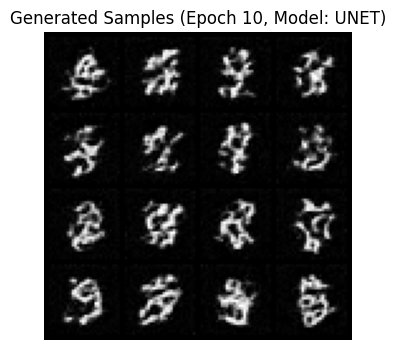

Epoch 11/100: 100%|██████████| 235/235 [00:41<00:00,  5.67it/s, batch_loss=39.4677]

Epoch [11/100] - Avg Loss: 38.7937



Epoch 12/100: 100%|██████████| 235/235 [00:40<00:00,  5.81it/s, batch_loss=37.7813]

Epoch [12/100] - Avg Loss: 38.1198



Epoch 13/100: 100%|██████████| 235/235 [00:41<00:00,  5.73it/s, batch_loss=36.4064]

Epoch [13/100] - Avg Loss: 37.0069



Epoch 14/100: 100%|██████████| 235/235 [00:40<00:00,  5.74it/s, batch_loss=36.0502]

Epoch [14/100] - Avg Loss: 36.3377



Epoch 15/100: 100%|██████████| 235/235 [00:42<00:00,  5.57it/s, batch_loss=38.0636]

Epoch [15/100] - Avg Loss: 35.6584



Epoch 16/100: 100%|██████████| 235/235 [00:43<00:00,  5.45it/s, batch_loss=34.3494]

Epoch [16/100] - Avg Loss: 35.0050



Epoch 17/100: 100%|██████████| 235/235 [00:43<00:00,  5.42it/s, batch_loss=36.4082]

Epoch [17/100] - Avg Loss: 34.6244



Epoch 18/100: 100%|██████████| 235/235 [00:43<00:00,  5.46it/s, batch_loss=34.5319]

Epoch [18/100] - Avg Loss: 34.0921



Epoch 19/100: 100%|██████████| 235/235 [00:42<00:00,  5.50it/s, batch_loss=35.4959]

Epoch [19/100] - Avg Loss: 33.6617



Epoch 20/100: 100%|██████████| 235/235 [00:41<00:00,  5.62it/s, batch_loss=32.8259]

Epoch [20/100] - Avg Loss: 33.3108


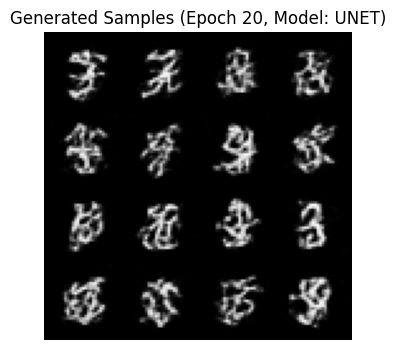

Epoch 21/100: 100%|██████████| 235/235 [00:41<00:00,  5.70it/s, batch_loss=32.3155]

Epoch [21/100] - Avg Loss: 33.1196



Epoch 22/100: 100%|██████████| 235/235 [00:38<00:00,  6.12it/s, batch_loss=31.7065]

Epoch [22/100] - Avg Loss: 32.6939



Epoch 23/100: 100%|██████████| 235/235 [00:37<00:00,  6.21it/s, batch_loss=32.4268]

Epoch [23/100] - Avg Loss: 32.4174



Epoch 24/100: 100%|██████████| 235/235 [00:38<00:00,  6.07it/s, batch_loss=31.9115]

Epoch [24/100] - Avg Loss: 32.3806



Epoch 25/100: 100%|██████████| 235/235 [00:39<00:00,  5.95it/s, batch_loss=34.5003]

Epoch [25/100] - Avg Loss: 31.9989



Epoch 26/100: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s, batch_loss=28.9898]

Epoch [26/100] - Avg Loss: 31.7408



Epoch 27/100: 100%|██████████| 235/235 [00:39<00:00,  5.94it/s, batch_loss=30.5257]

Epoch [27/100] - Avg Loss: 31.5979



Epoch 28/100: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s, batch_loss=32.8935]

Epoch [28/100] - Avg Loss: 31.4311



Epoch 29/100: 100%|██████████| 235/235 [00:40<00:00,  5.85it/s, batch_loss=33.3098]

Epoch [29/100] - Avg Loss: 31.1602



Epoch 30/100: 100%|██████████| 235/235 [00:40<00:00,  5.80it/s, batch_loss=30.3828]

Epoch [30/100] - Avg Loss: 31.0122


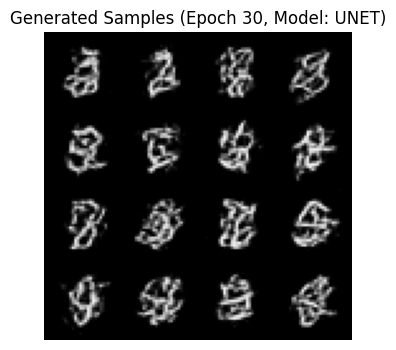

Epoch 31/100: 100%|██████████| 235/235 [00:40<00:00,  5.82it/s, batch_loss=30.8463]

Epoch [31/100] - Avg Loss: 30.8493



Epoch 32/100: 100%|██████████| 235/235 [00:40<00:00,  5.86it/s, batch_loss=30.2613]

Epoch [32/100] - Avg Loss: 30.7512



Epoch 33/100: 100%|██████████| 235/235 [00:40<00:00,  5.84it/s, batch_loss=30.6440]

Epoch [33/100] - Avg Loss: 30.6669



Epoch 34/100: 100%|██████████| 235/235 [00:41<00:00,  5.63it/s, batch_loss=29.9379]

Epoch [34/100] - Avg Loss: 30.5848



Epoch 35/100: 100%|██████████| 235/235 [00:39<00:00,  5.98it/s, batch_loss=30.1948]

Epoch [35/100] - Avg Loss: 30.5045



Epoch 36/100: 100%|██████████| 235/235 [00:39<00:00,  5.94it/s, batch_loss=29.4055]

Epoch [36/100] - Avg Loss: 30.3751



Epoch 37/100: 100%|██████████| 235/235 [00:39<00:00,  5.91it/s, batch_loss=32.6321]

Epoch [37/100] - Avg Loss: 31.2658



Epoch 38/100: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s, batch_loss=30.7191]

Epoch [38/100] - Avg Loss: 31.3432



Epoch 39/100: 100%|██████████| 235/235 [00:40<00:00,  5.83it/s, batch_loss=32.1185]

Epoch [39/100] - Avg Loss: 30.5759



Epoch 40/100: 100%|██████████| 235/235 [00:39<00:00,  5.90it/s, batch_loss=32.7437]

Epoch [40/100] - Avg Loss: 30.3575


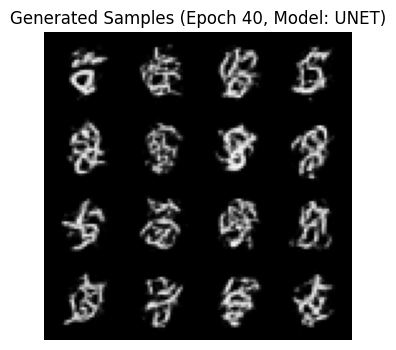

Epoch 41/100: 100%|██████████| 235/235 [00:40<00:00,  5.86it/s, batch_loss=30.9832]

Epoch [41/100] - Avg Loss: 30.1818



Epoch 42/100: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s, batch_loss=30.7940]

Epoch [42/100] - Avg Loss: 30.0680



Epoch 43/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=28.3590]

Epoch [43/100] - Avg Loss: 29.9862



Epoch 44/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=28.9796]

Epoch [44/100] - Avg Loss: 29.8680



Epoch 45/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=30.5237]

Epoch [45/100] - Avg Loss: 29.7354



Epoch 46/100: 100%|██████████| 235/235 [00:40<00:00,  5.84it/s, batch_loss=28.6883]

Epoch [46/100] - Avg Loss: 29.6554



Epoch 47/100: 100%|██████████| 235/235 [00:40<00:00,  5.85it/s, batch_loss=30.9581]

Epoch [47/100] - Avg Loss: 29.6243



Epoch 48/100: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s, batch_loss=29.8075]

Epoch [48/100] - Avg Loss: 29.5737



Epoch 49/100: 100%|██████████| 235/235 [00:39<00:00,  5.90it/s, batch_loss=30.1247]

Epoch [49/100] - Avg Loss: 29.4842



Epoch 50/100: 100%|██████████| 235/235 [00:40<00:00,  5.78it/s, batch_loss=30.7565]

Epoch [50/100] - Avg Loss: 29.5468


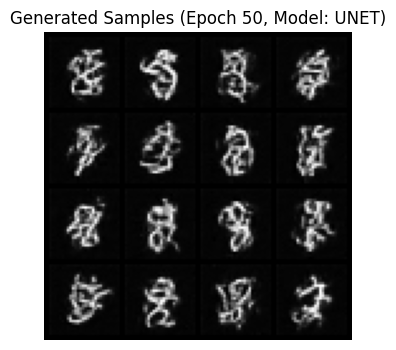

Epoch 51/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=29.8743]

Epoch [51/100] - Avg Loss: 29.4293



Epoch 52/100: 100%|██████████| 235/235 [00:40<00:00,  5.84it/s, batch_loss=27.6679]

Epoch [52/100] - Avg Loss: 29.3875



Epoch 53/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=28.9726]

Epoch [53/100] - Avg Loss: 29.3070



Epoch 54/100: 100%|██████████| 235/235 [00:40<00:00,  5.86it/s, batch_loss=29.6151]

Epoch [54/100] - Avg Loss: 29.2734



Epoch 55/100: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s, batch_loss=29.8936]

Epoch [55/100] - Avg Loss: 29.2452



Epoch 56/100: 100%|██████████| 235/235 [00:40<00:00,  5.83it/s, batch_loss=28.6236]

Epoch [56/100] - Avg Loss: 29.1695



Epoch 57/100: 100%|██████████| 235/235 [00:38<00:00,  6.12it/s, batch_loss=29.7832]

Epoch [57/100] - Avg Loss: 29.2434



Epoch 58/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=31.0005]

Epoch [58/100] - Avg Loss: 29.1784



Epoch 59/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=30.0850]

Epoch [59/100] - Avg Loss: 29.1425



Epoch 60/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=28.6406]

Epoch [60/100] - Avg Loss: 29.0847


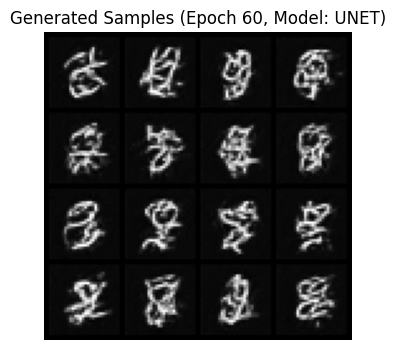

Epoch 61/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.4353]

Epoch [61/100] - Avg Loss: 28.9357



Epoch 62/100: 100%|██████████| 235/235 [00:36<00:00,  6.43it/s, batch_loss=28.0743]

Epoch [62/100] - Avg Loss: 29.0421



Epoch 63/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=31.2265]

Epoch [63/100] - Avg Loss: 29.0014



Epoch 64/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=28.8469]

Epoch [64/100] - Avg Loss: 28.9583



Epoch 65/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.5455]

Epoch [65/100] - Avg Loss: 28.8131



Epoch 66/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=30.3109]

Epoch [66/100] - Avg Loss: 28.8534



Epoch 67/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=30.5484]

Epoch [67/100] - Avg Loss: 28.8125



Epoch 68/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=35.5547]

Epoch [68/100] - Avg Loss: 28.7789



Epoch 69/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=25.8364]

Epoch [69/100] - Avg Loss: 28.8289



Epoch 70/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.8769]

Epoch [70/100] - Avg Loss: 28.7806


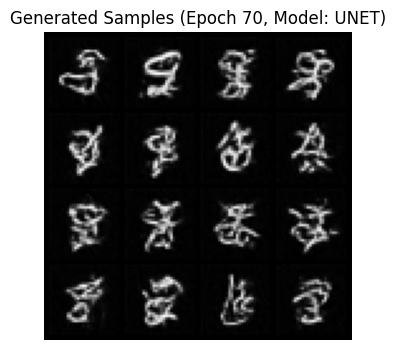

Epoch 71/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=28.5346]

Epoch [71/100] - Avg Loss: 28.8008



Epoch 72/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.8046]

Epoch [72/100] - Avg Loss: 28.6185



Epoch 73/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=28.4120]

Epoch [73/100] - Avg Loss: 28.6978



Epoch 74/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=33.1110]

Epoch [74/100] - Avg Loss: 28.6921



Epoch 75/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=29.3455]

Epoch [75/100] - Avg Loss: 28.6712



Epoch 76/100: 100%|██████████| 235/235 [00:36<00:00,  6.35it/s, batch_loss=29.0824]

Epoch [76/100] - Avg Loss: 28.5681



Epoch 77/100: 100%|██████████| 235/235 [00:37<00:00,  6.20it/s, batch_loss=27.8812]

Epoch [77/100] - Avg Loss: 28.6650



Epoch 78/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=29.2522]

Epoch [78/100] - Avg Loss: 28.5049



Epoch 79/100: 100%|██████████| 235/235 [00:37<00:00,  6.20it/s, batch_loss=28.1062]

Epoch [79/100] - Avg Loss: 28.5060



Epoch 80/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=27.5483]

Epoch [80/100] - Avg Loss: 28.5620


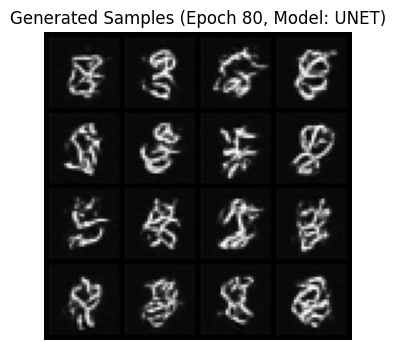

Epoch 81/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=29.3315]

Epoch [81/100] - Avg Loss: 28.4917



Epoch 82/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=27.6914]

Epoch [82/100] - Avg Loss: 28.4815



Epoch 83/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=28.1362]

Epoch [83/100] - Avg Loss: 28.4059



Epoch 84/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=29.0488]

Epoch [84/100] - Avg Loss: 29.1817



Epoch 85/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=28.7883]

Epoch [85/100] - Avg Loss: 29.1838



Epoch 86/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=27.3149]

Epoch [86/100] - Avg Loss: 28.8119



Epoch 87/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=30.9190]

Epoch [87/100] - Avg Loss: 28.5894



Epoch 88/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=29.4408]

Epoch [88/100] - Avg Loss: 28.5821



Epoch 89/100: 100%|██████████| 235/235 [00:36<00:00,  6.36it/s, batch_loss=28.6320]

Epoch [89/100] - Avg Loss: 28.4577



Epoch 90/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=27.5810]

Epoch [90/100] - Avg Loss: 28.4208


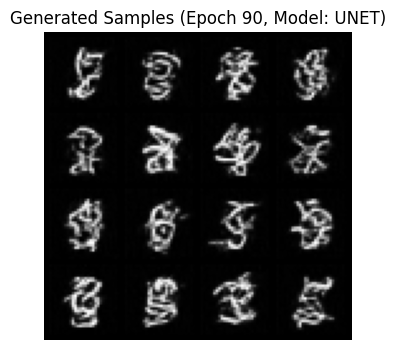

Epoch 91/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=30.2758]

Epoch [91/100] - Avg Loss: 28.4156



Epoch 92/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=26.9733]

Epoch [92/100] - Avg Loss: 28.3533



Epoch 93/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.1366]

Epoch [93/100] - Avg Loss: 28.3049



Epoch 94/100: 100%|██████████| 235/235 [00:38<00:00,  6.17it/s, batch_loss=28.8395]

Epoch [94/100] - Avg Loss: 28.2826



Epoch 95/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=29.3597]

Epoch [95/100] - Avg Loss: 28.2741



Epoch 96/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=27.6796]

Epoch [96/100] - Avg Loss: 28.2164



Epoch 97/100: 100%|██████████| 235/235 [00:38<00:00,  6.16it/s, batch_loss=27.8612]

Epoch [97/100] - Avg Loss: 28.2388



Epoch 98/100: 100%|██████████| 235/235 [00:37<00:00,  6.19it/s, batch_loss=28.7931]

Epoch [98/100] - Avg Loss: 28.1904



Epoch 99/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=28.3898]

Epoch [99/100] - Avg Loss: 28.2460



Epoch 100/100: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, batch_loss=29.2050]

Epoch [100/100] - Avg Loss: 28.2121


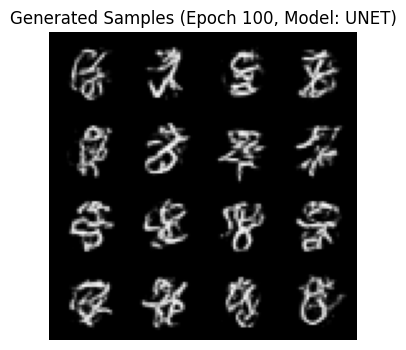

In [3]:
print("--- Training UNET Model ---")
run_noise_predictor(
    model_type="unet", # Specify Unet
    alpha=0.7,
    epochs=100, 
    batch_size=256,
    lr=1e-3,    
    show_every=10, # Show every 10 epochs for Unet
    base_dim=32,
    dim_mults=(1, 2, 4),
    num_res_blocks_encoder=2,
    num_res_blocks_decoder=2,
    num_res_blocks_mid=1,
    log_freq=100,
    n_samples=16,
)

As you can see, it kinda learns how to generate the digits, but not really. One step diffusion is not easy. Even with a better neural network (U-Net vs. Conv) that is often used in diffusion, we are not getting better results.

That's why multi step diffusion models are more common. Also the problem is that corrupting $x_{0}$ with noise to make $x_{1}$, won't make it a normal Gaussian, unless $\alpha$ is 0. But if it's set to 0, then the decoder can't learn anything since there is no signal in $x_{1}$, but only noise.